# `pyiron_workflow` on HPC

## Running an entire graph on HPC

We've seen how nodes can be saved and loaded, how we can tell a node to make a "checkpoint" save  of its graph when it finishes running, and how we (by default) get "recovery" save files if the workflow encounters an error. These are all the pieces we need to be able to send a workflow off for remote submission on high performance computing (HPC)!


`pyiron_workflow` itself does not provide an explicit interface to HPC compute, although convenience functions built around `pysqa` are highly likely to appear in the future. In the meantime, running on resources that are remote (i.e. _not_ dependent on this local python process) is as simple as:
- Saving the node locally
- Remotely:
  - Loading that save file
  - Running the node
  - Saving again

Here we'll do this by building a super-simple wrapper function that saves, then writes a SLURM script that loads, runs, and saves, and submit that script with `sbatch`. This wrapper is specific to my particular cluster, and won't work out-of-the-box for you -- but it demonstrates the fundamental compatibility between `pyiron_workflow` and file-based execution.

In [1]:
import pyiron_workflow as pwf
from time import sleep, perf_counter

In [2]:
def submit_to_slurm(
    node,
    /,
    job_name=None,
    output_file=None,
    error_file=None,
    time_limit="00:05:00",
    account="mpd",
    partition="s.cmmg",
    nodes=1,
    ntasks=1,
    cpus_per_task=1,
    memory="1GB",
):
    """
    An example of a helper function for running nodes on slurm.

    - Saves the node
    - Writes a slurm batch script that 
        - Loads the node
        - Runs it
        - Saves it again
    - Runs the batch script
    """
    if node.graph_root is not node:
        raise ValueError(
            f"Can only submit parent-most nodes, but {node.full_label} "
            f"has root {node.graph_root.full_label}"
        )
        
    node.save(backend="pickle")
    p = node.as_path()
    
    if job_name is None:
        job_name = node.full_label 
        job_name = job_name.replace(node.semantic_delimiter, "_")
        job_name = "pwf" + job_name
        
    script_content = f"""#!/bin/bash
#SBATCH --job-name={job_name} 
#SBATCH --output={p.joinpath("slurm.out").resolve() if output_file is None else output_file}
#SBATCH --error={p.joinpath("slurm.err").resolve() if error_file is None else error_file}
#SBATCH --time={time_limit}
#SBATCH --account={account}
#SBATCH --partition={partition}
#SBATCH --nodes={nodes}
#SBATCH --ntasks={ntasks}
#SBATCH --cpus-per-task={cpus_per_task}
#SBATCH --mem={memory}

# Execute Python script inline
python - <<EOF
from pyiron_workflow import PickleStorage
node = PickleStorage().load(filename="{node.as_path().joinpath('picklestorage').resolve()}")  # Load
node.run()  # Run
node.save(backend="pickle")  # Save again
EOF
"""
    submission_script = p.joinpath("node_submission.sh")
    submission_script.write_text(script_content)
    import subprocess
    submission = subprocess.run(["sbatch", submission_script.resolve()])
    return submission

def delete_path(path):
    """
    Delete everything in a one-deep pathlib Path, then delete it too.

    Just a little convenience so we can clean up the files we make here.
    """
    for file in path.iterdir():
        file.unlink()
    path.rmdir()

### Running on slurm

Here we have an easy but intentionally slow workflow so we can use `squeue` to quickly verify that the job really is running on the cluster.

We'll follow the same six steps in each example:
- Build the workflow
- Send it off to the queue (includes a `.save()` call)
- Reload it (make sure the `.save()` has finished!)
- Keep reloading it until we can tell it's done (you could also just look in the SLURM queue, but we need a way to automate it here)
- Discuss what we can see
- Finally, clean up any files we made

In [3]:
# Build the workflow
wf = pwf.Workflow("slurmflow")
wf.sleep_time = pwf.standard_nodes.UserInput(2)
wf.skipped_my_nap = 0 * wf.sleep_time
wf.sleep = pwf.standard_nodes.Sleep(wf.sleep_time)
wf.floating_dreams = pwf.standard_nodes.Float(wf.sleep)

# Send it off
submit_to_slurm(wf)

# Try reloading it (need to wait for `submit_to_slurm`)
while not wf.has_saved_content():
    sleep(0.2)
reloaded = pwf.Workflow(wf.label)

# Reload it until it's done
while reloaded.floating_dreams.outputs.float.value is pwf.NOT_DATA:
    reloaded.load()
    print(reloaded.sleep.outputs.time.value)
    sleep(1)
reloaded.outputs.to_value_dict()

Submitted batch job 9445778
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
NOT_DATA
2


{'skipped_my_nap__rmul': 0, 'floating_dreams__float': 2.0}

Here we see that after the initial `.save()` call in `submit_to_slurm` but before the job is finished, the final output is `NOT_DATA` -- we can tell the final `.save()` in the SLURM script got called once this is no longer the case and we load something new!

In [4]:
delete_path(wf.as_path())

### Checkpoints

This example is very similar, except one of our intermediate nodes is set as a "checkpoint" node, which will save the graph when it finishes running. This may be useful if you have a large workflow and want to be able to start examining intermediate results before the whole graph has finished running!

In [5]:
wf = pwf.Workflow("checkpointing")
wf.sleep_time = pwf.standard_nodes.UserInput(5)
wf.sleep = pwf.standard_nodes.Sleep(wf.sleep_time)
wf.sleep_again = pwf.standard_nodes.Sleep(wf.sleep)

wf.sleep.checkpoint = "pickle"
submit_to_slurm(wf)

while not wf.has_saved_content():
    sleep(0.2)
reloaded = pwf.Workflow(wf.label)
    
while reloaded.sleep_again.outputs.time.value is pwf.NOT_DATA:
    reloaded.load()
    print(reloaded.sleep.outputs.time.value, reloaded.sleep_again.outputs.time.value)
    sleep(1)

Submitted batch job 9445782
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
NOT_DATA NOT_DATA
5 NOT_DATA
5 NOT_DATA
5 NOT_DATA
5 NOT_DATA
5 NOT_DATA
5 5


We can see that initially there's a few seconds where all the (de)serialization is happening to get the job running, followed by five seconds of running where the checkpoint job `wf.sleep` hasn't finished yet -- both outputs are `NOT_DATA`. But then the checkpoint save is made _and the job keeps running_, so we can see the intermediate data `5`, while the later node hasn't finished yet. Finally, both nodes finish and the SLURM job makes its final save.

In [6]:
delete_path(wf.as_path())

### Recovering from failure

By default, any node that raises an exception will act as a checkpoint node at the time of failure `finally:` making a save after raising the exception. This means that if we have some expensive workflow and one of the nodes goes wrong and raises an error, all is not lost! The node will save a "recovery" file at the point of failure, which we can come back and investigate, extracting data and/or repairing it for a re-run (remember that non-failed nodes will (by default) have cached values, so re-running those parts is usually very fast).

Submitted batch job 9445785


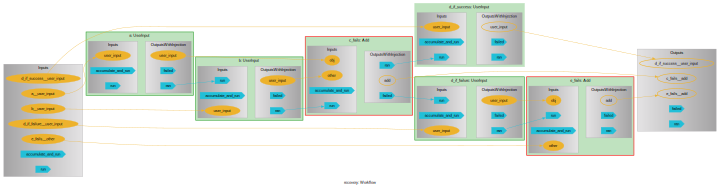

In [7]:
wf = pwf.Workflow("recovery")
wf.a = pwf.standard_nodes.UserInput(1)
wf.b = pwf.standard_nodes.UserInput("two")
wf.c_fails = wf.a + wf.b  # Type error
wf.d_if_success = pwf.standard_nodes.UserInput(0)
wf.d_if_failure = pwf.standard_nodes.UserInput("But what's the question?")
wf.e_fails = pwf.standard_nodes.Add(wf.d_if_failure, 42)  # Type error

wf.a >> wf.b >> wf.c_fails >> wf.d_if_success
wf.c_fails.signals.output.failed >> wf.d_if_failure >> wf.e_fails
wf.starting_nodes = [wf.a]
wf.automate_execution = False

submit_to_slurm(wf)

while not wf.has_saved_content():
    sleep(0.2)
reloaded = pwf.Workflow(wf.label)
    
while not reloaded.e_fails.failed:
    if reloaded.has_saved_content(
        filename=wf.as_path().joinpath("recovery")
    ):
        reloaded.load(
            filename=wf.as_path().joinpath("recovery")
        )
    else:
        sleep(1)
reloaded.draw(size=(10, 10))

In [8]:
print(reloaded.label, "failed?", reloaded.failed)
for child in reloaded:
    if child.failed:
        print(child.label, "failed")

recovery failed? True
c_fails failed
e_fails failed


We can see that the recovery file saved for us the final breath of our failed workflow.

In [9]:
delete_path(wf.as_path())

### Executors inside an HPC job

Executor objects can't be saved and loaded -- consequently they get purged in the save process. So while we could write an entire `.py` script that defines and runs our workflow, including setting executors as usual, and ship the _whole_ `.py` script off as a slurm job, our little helper function won't help -- if we set executors in the naive way they'll be stripped off at the `.save()` step!

To get around this, instead of setting an executor instance explicitly, `pyiron_workflow` instead allows us to set _instructions_ for how to make an executor, in the form `callable, tuple, dict` for the constructor, args, and kwargs. The simplest thing is just to pass an executor class, like `concurrent.futures.ProcessPoolExecutor, (), {"max_workers": 4}`, but any callable will do. Since we can use any callable we can even exploit this to give multiple nodes the same executor instance -- e.g. by having a separate `.py` file that instantiates a global executor, and pass a method that imports this. There is no hand-holding here, so if you want to do something fancy you need to do it yourself, but the framework is intended to give enough flexibility to get done what you need to get done.

In our final example we'll explore this by running our `Sleep` nodes with a thread pool executor so they can all sleep at (more or less) the same time. We'll also do something else a bit different here: instead of sending a `Workflow` off, we'll send a particular node. In this case, a `For`-node, and we'll use the `body_node_executor` attribute to pass our executor (well, executor building instructions) to each child `Sleep` node individually.

In [10]:
from concurrent.futures import ThreadPoolExecutor
import time

# Build the workflow
looped = pwf.standard_nodes.Sleep.for_node(
    iter_on=("t",),
    t=100*[6],
)
looped.body_node_executor = (ThreadPoolExecutor, (), {})

# Start timing 
t0 = perf_counter()

# Send it off
submit_to_slurm(looped)

# Try reloading it (need to wait for `submit_to_slurm`
while not looped.has_saved_content():
    sleep(0.2)
reloaded = pwf.standard_nodes.Sleep.for_node(
    iter_on=("t",),
    label=looped.label,
)
reloaded.load()

# Reload it until it's done
while reloaded.outputs.df.value is pwf.NOT_DATA:
    reloaded.load()
    sleep(1)

# Stop timing
dt = perf_counter() - t0

print("Total duration (s) =", dt)
reloaded.outputs.df.value

Submitted batch job 9445786
Total duration (s) = 12.557957572862506


,t,time
0,6,6
1,6,6
2,6,6
3,6,6
4,6,6
...,...,...
95,6,6
96,6,6
97,6,6
98,6,6


With 100 six-second sleep nodes, in the absence of parallelization we would expect this workflow to take about 10 minutes to complete -- here it finishes in 10 seconds. There is some overhead to shipping a workflow off to SLURM, both in terms of (de)serialization and waiting in the queue, but if you need parallel processing beyond what you can get on the head node, this is the way to go.

The example here was a simple python command with thread parallelization, but there is no barrier to exploiting nodes that `subprocess.run(["mpiexec", "-n", ...])` inside a `ProcessPoolExecutor` and really get cooking. You should be able to leverage multiple compute nodes with `executorlib` executors, but this is not tested yet.

The only "gotcha" to remember is that _nesting_ executors is still not possible -- once an executor has been applied to a node, no executor can be applied to any of that node's children. (This may be forthcoming in `executorlib` under certain conditions, so watch there for independent developments.)

In [11]:
delete_path(looped.as_path())

## Executing a single node remotely

Instead of running the entire graph on remote resources, we might want to run just a single node remotely. This is the standard way of parallelizing graphs, and is done by the node's `.executor` attribute -- as long as we have an `Executor` that knows how to send calculations to remote compute! Conveniently, `executorlib.Executor` can do exactly this, e.g.

In [13]:
wf = pwf.Workflow("living_process")
wf.sleep_time = pwf.standard_nodes.UserInput(5)
wf.skipped_my_nap = 0 * wf.sleep_time
wf.sleep = pwf.standard_nodes.Sleep(wf.sleep_time)
wf.floating_dreams = pwf.standard_nodes.Float(wf.sleep)

with pwf.Workflow.create.ExecutorlibExecutor(
    max_cores=1, 
    backend="slurm", 
    command_line_argument_lst=[
        "-n 1",
        "-N 1",
        "--account=mpd",
        "--partition=s.cmmg",
        "--time=00:00:30",
    ]
) as exe:
    wf.sleep.executor = exe
    wf()

wf.outputs.to_value_dict()

srun: job 9445792 queued and waiting for resources
srun: job 9445792 has been allocated resources


{'skipped_my_nap__rmul': 0, 'floating_dreams__float': 5.0}

If we go look at our slurm queue, we can see that `wf.sleep` did indeed get run on the cluster rather than locally in this python process. So running a node on the cluster really is that straightforward. But, here's the catch: this only works while the parent python process (i.e. this notebook) stays alive for the duration of the calculation?

Since we're probably submitting things to HCP because they are computationally expensive, how do we handle submitting an individual node to remote processing and then _killing the parent python process?_ E.g. we start our workflow running, but shutdown our notebook once it's stuck waiting for expensive jobs in the cluster queue.

### Restarting the local processes

From the `pyiron_workflow` side, the answer is relatively straightforward: we need to tell the executor not just to run the node as usual, but also to create a serialized dump of the run result.

If the parent process stays alive until the `Future` returned by the executor finishes, we process it as usual and it's like nothing was different -- just like the simple `executorlib` example above. However, if the parent process _dies_, and we reload the checkpoint file, we'll find that the node is still in the "running" state. At this point, we want to see if the extra serialzied result we asked for is present (in which case we can load it and keep going), or not (in which case we can simply fail because the workflow is not ready to keep going). 

As before, a real and robust interface for this process should certainly leverage `pysqa`, and may also leverage `executorlib.FileExecutor`. In this case, we just make the bare minimal "executor" that will use cloudpickle to run our node's `on_run` in an independent python process:

In [15]:
from concurrent.futures import Executor, Future
import os
from subprocess import Popen

import cloudpickle

class FakeExecutor(Executor):
    """
    Just a silly executor that uses cloudpickle to start a function
    on an independent python process -- the future will never even resolve!
    """
    def submit(self, fn, /, *args, **kwargs):
        with open("fake_executor_data.cpkl", "wb") as f:
            cloudpickle.dump((fn, args, kwargs), f)

        commands = """
import cloudpickle
with open("fake_executor_data.cpkl", "rb") as f:
    fn, args, kwargs = cloudpickle.load(f)
fn(*args, **kwargs)
"""
        Popen(["python", "-c", commands], preexec_fn=os.setsid)
        return Future()

We'll build a super simple workflow, and then manually kill it while the slow, remotely executed node is still running. Since the node can't tell from the mere presence of an executor that this executor can survive the death of the parent python process, we need to manually let the relevant nodes know they should `._serialize_result`:

In [16]:
wf = pwf.Workflow("killed_process")
wf.sleep_time = pwf.standard_nodes.UserInput(2)
wf.skipped_my_nap = 0 * wf.sleep_time
wf.sleep = pwf.standard_nodes.Sleep(wf.sleep_time)
wf.floating_dreams = pwf.standard_nodes.Float(wf.sleep)

with FakeExecutor() as exe:
    wf.sleep._serialize_result = True
    wf.sleep.executor = exe
    wf()

KeyboardInterrupt: 

Killing the process creates a recovery file we can load, where the workflow is in a failed state

In [17]:
wf.load(filename=wf.as_path().joinpath("recovery"))
wf.failed

True

We can see that at the time the graph process was killed, the `wf.sleep` node was still running (outlined in orange):

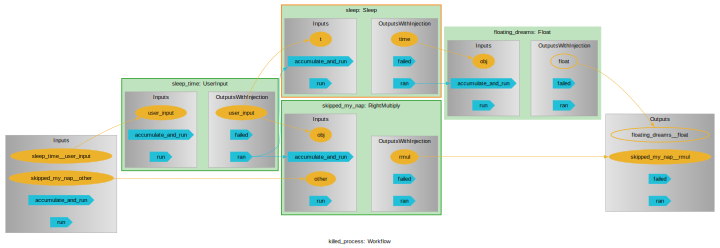

In [18]:
wf.draw(size=(10, 10))

We can look in the filesystem along the remotely-executed node's semantic path to see when the `run_result.tmp` file is available, this is the cloudpickled result from the remote execution. (In a real case we'd probably be more conveniently looking at a list of jobs running on the queue to see if ours was finished, or leveraging some other syntactic shortcut to see if the job is done, but convenient UI tools around this functionality aren't done yet.)

Now we simply reset the failed status and run the workflow again:

In [19]:
wf.failed = False
wf()

{'skipped_my_nap__rmul': 0, 'floating_dreams__float': 2.0}

If we had tried this too early at the results file wasn't there yet, we'd have simply failed again with a message to that effect. As it is, when the `running` `wf.sleep` node re-ran, it saw that its results file was available, unpickled it, processed it, and we continued running.

Remember that (as long as caching is being used), all the green-rimmed nodes above have already run and will re-run extremely quickly, so it should always be quite fast to "catch up" to these slow, remotely executed parts of the graph.

If we look again, we see the entire graph is run:

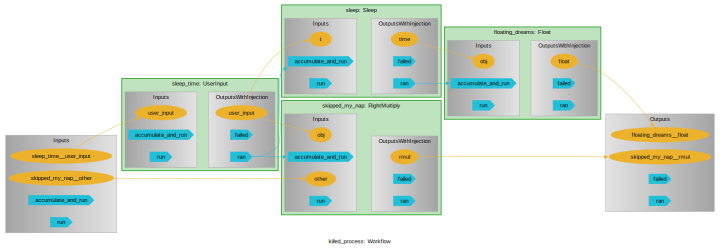

In [20]:
wf.draw(size=(10, 10))

In [21]:
# Cleanup
wf.delete_storage(filename=wf.as_path().joinpath("recovery"))
wf.sleep._clean_graph_directory()

Running an entire graph remotely by saving then (loading, running, saving), and running individual nodes remotely with powerful executors _while the parent python process outlives the node run_ are both stable and reliable ways to parallelize your workflow. There's no guarantee you won't discover some unpleasant edge case, but overall you should expect quite smooth sailing.

Running an individual node remotely and _killing the parent python process_ is a feature still under development, hence `_serialize_result` is still a private attribute. In particular, there are no guardrails against re-loading a killed graph with one or more remotely run children, and changing its input prior to re-running -- this would result in the loaded result file no longer being in sync with the node input! The power is available, but is still at a stage where it requires responsibility to wield it.